In [1]:
#%% Dependencies
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
import WormTool.timeseries
import os
import scipy.io
import importlib
importlib.reload(WormTool.timeseries)
import pickle
import statsmodels.api as sm
from find_excursion import ExcurInfo

In [15]:
name_ls = ['N2','RMDk','SMDk','SMBk']
data_ls = []
for name in name_ls:
    with open('../neuron_ablations/processed/{}_trial_info.pkl'.format(name), 'rb') as f:
        trial_info = pickle.load(f)
        data_ls.append(trial_info)
        
print(trial_info[0].keys())
# curvature shape
print(trial_info[0]['curvature'].shape)
print(trial_info[0]['headcast_info'].keys())

# Get head phase from eigenhead plane
def calc_head_body_phase(curvature, head_eigenworms, body_eigenworms):
    head_curv = curvature[:30]
    body_curv = curvature[30:]
    head_curv_proj = head_curv.T@head_eigenworms[:,:2]
    body_curv_proj = body_curv.T@body_eigenworms[:,:2]
    head_phase = np.arctan2(head_curv_proj[:,1], -head_curv_proj[:,0])
    head_phase_pos_jump = np.where(np.diff(head_phase)>1.9*np.pi)[0]
    head_phase_neg_jump = np.where(np.diff(head_phase)<-1.9*np.pi)[0]
    for i in head_phase_pos_jump:
        # find the negative jump that is right after the positive jump
        next_drop = np.where(head_phase_neg_jump>i)[0]
        if len(next_drop)>0:
            j = head_phase_neg_jump[next_drop[0]]
            head_phase[i+1:j+1] = head_phase[i+1:j+1] - 2*np.pi
        else:
            head_phase[i+1:] = head_phase[i+1:] - 2*np.pi
    body_phase = np.arctan2(body_curv_proj[:,1], -body_curv_proj[:,0])
    body_phase_pos_jump = np.where(np.diff(body_phase)>1.9*np.pi)[0]
    body_phase_neg_jump = np.where(np.diff(body_phase)<-1.9*np.pi)[0]
    for i in body_phase_pos_jump:
        # find the negative jump that is right after the positive jump
        next_drop = np.where(body_phase_neg_jump>i)[0]
        if len(next_drop)>0:
            j = body_phase_neg_jump[next_drop[0]]
            body_phase[i+1:j+1] = body_phase[i+1:j+1] - 2*np.pi
        else:
            body_phase[i+1:] = body_phase[i+1:] - 2*np.pi
    return head_phase, body_phase


dict_keys(['worm_id', 'time', 'head_curv', 'curvature', 'orientation', 'com_pos', 'denoised', 'phase', 'headcast_info', 'description'])
(100, 310)
dict_keys(['duration', 'amplitude', 'rel_amplitude', 'start_ind', 'end_ind', 'sign'])


**Calculate headcast amplitude-phase joint distribution**

/var/folders/n5/v1fxkwkd3fq172p487cvzxq40000gn/T/ipykernel_50664/2944961287.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pcm = ax[ii,jj].pcolormesh(phase_mesh,amp_mesh, phase_amp_density_log.T, cmap='Reds', vmax=-3.5,vmin=-5.2)


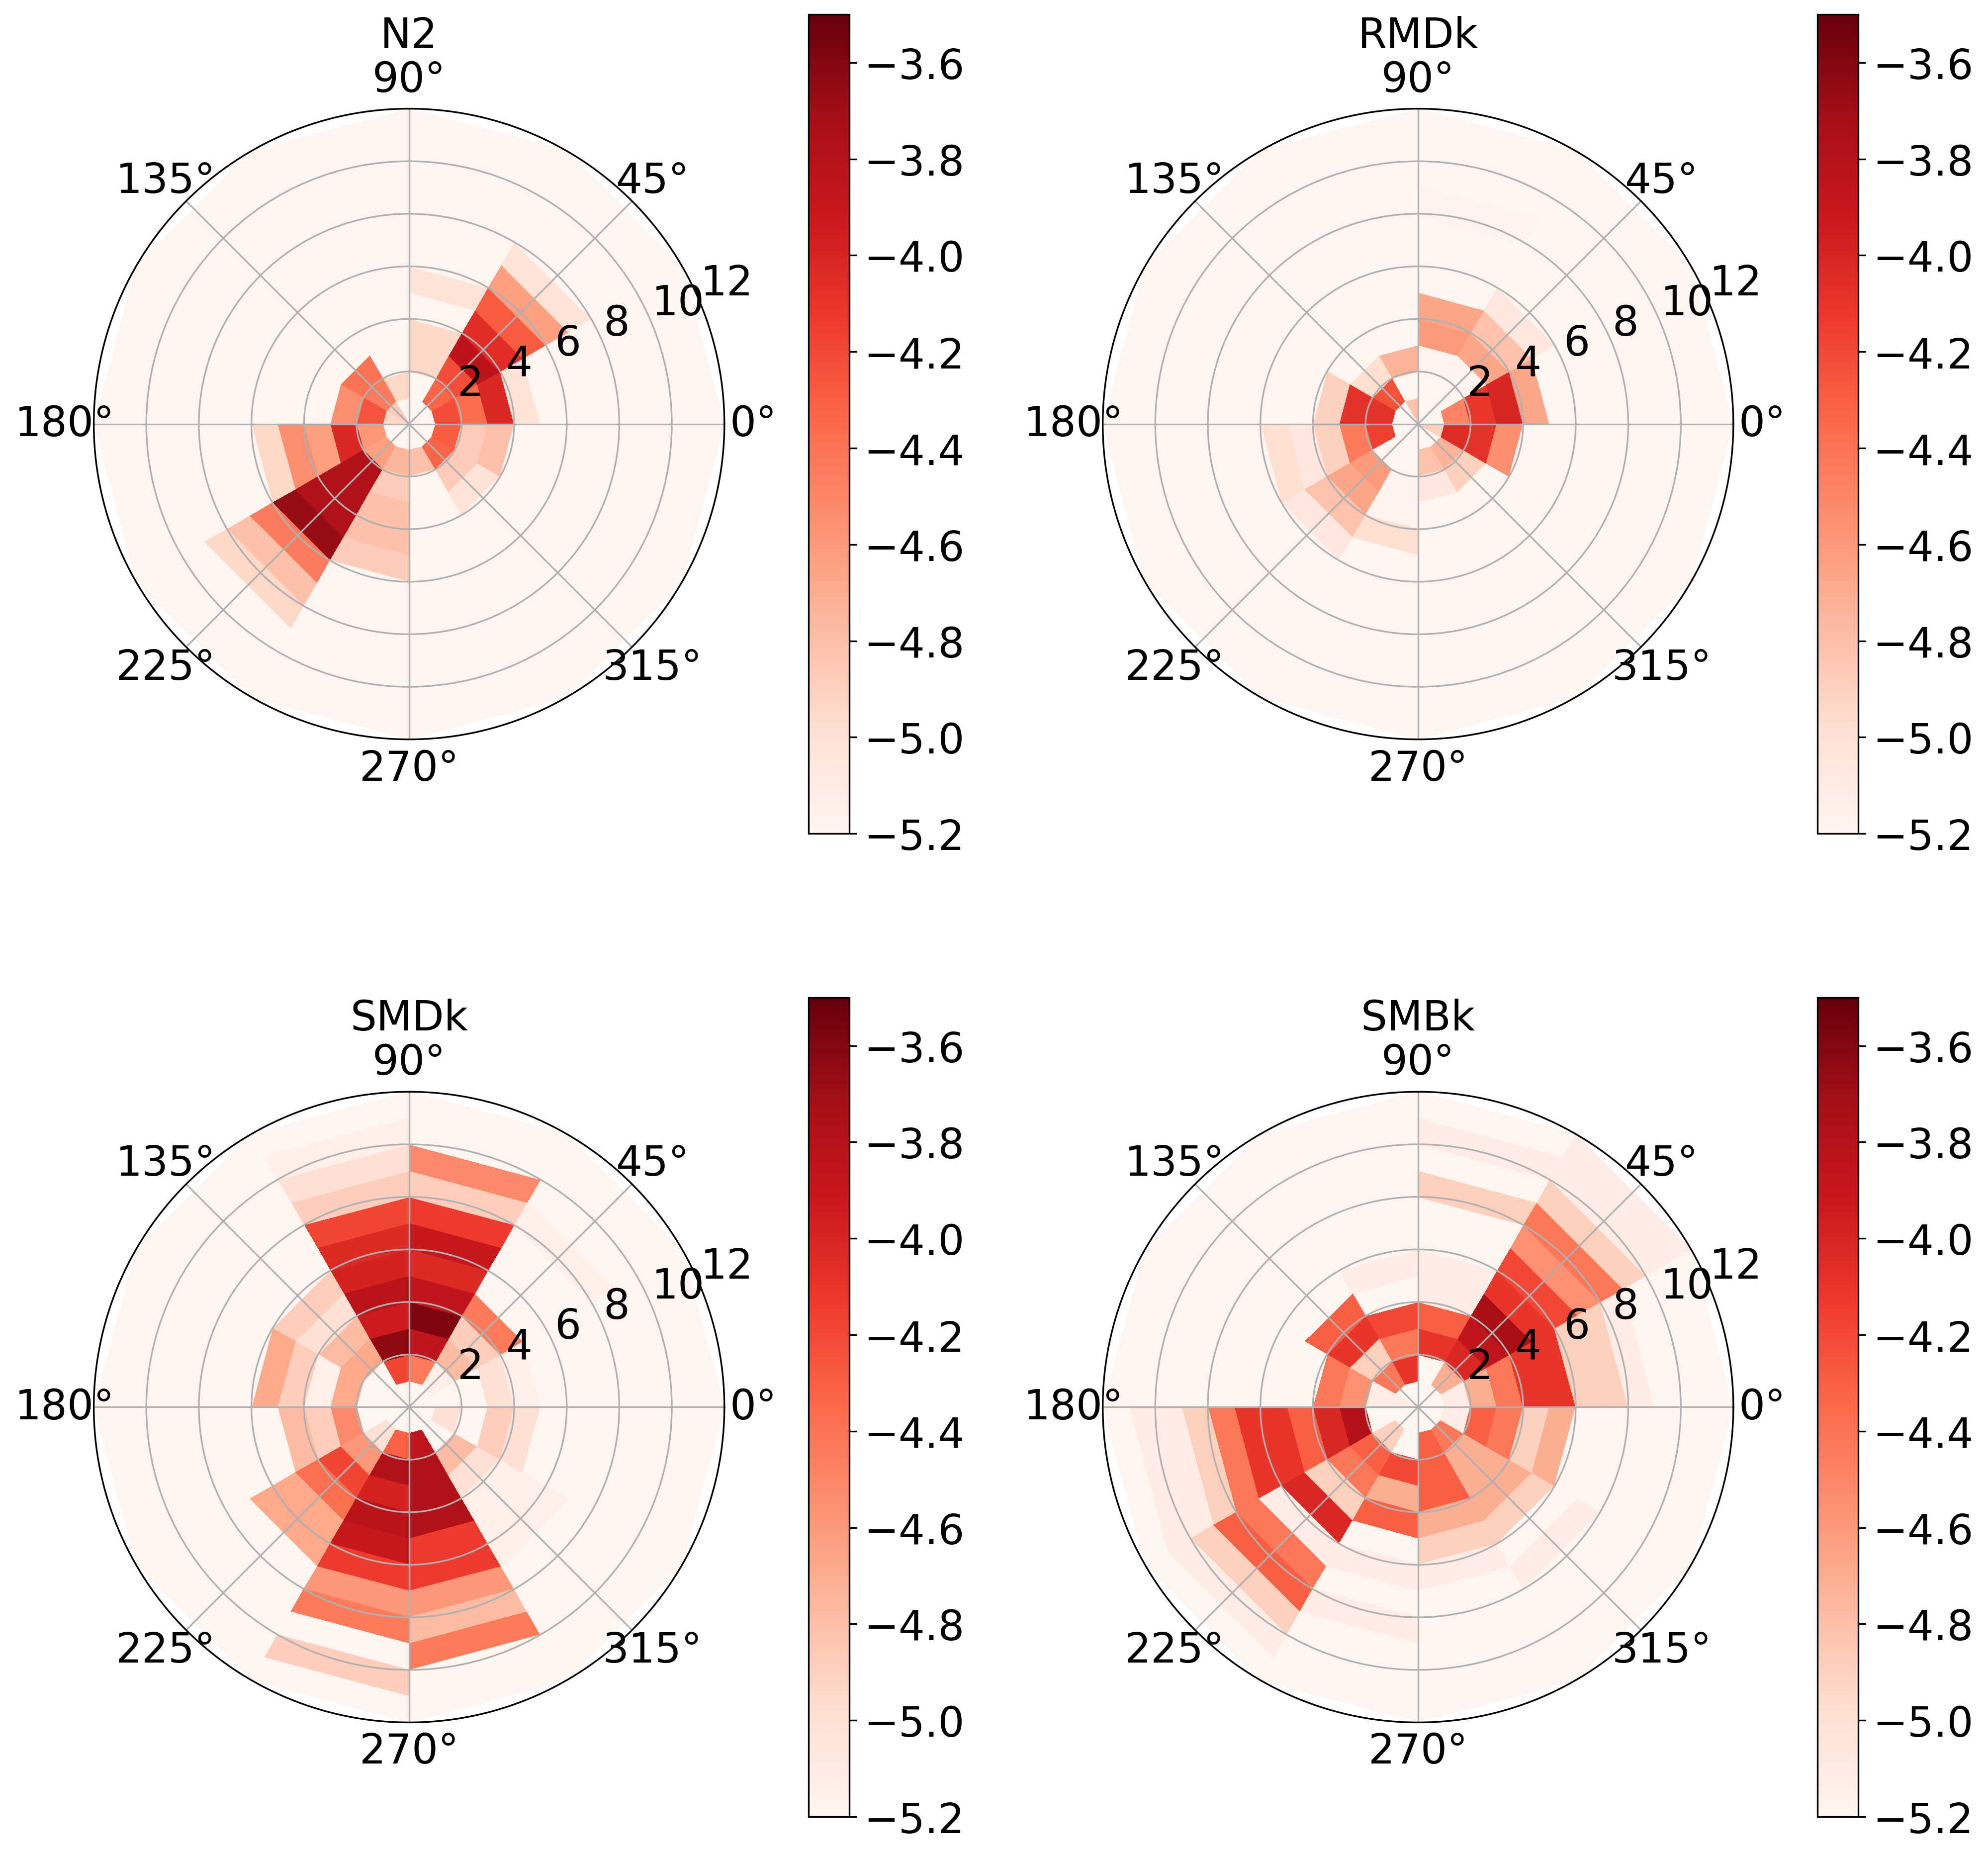

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16),dpi=300,subplot_kw=dict(projection='polar'))
for ii in range(2):
    for jj in range(2):
        headcast_phase_ls = []
        headcast_amplitude_ls = []
        headcast_rel_amp_ls = []
        data_len_all = 0
        head_eigenworms = np.load('../excursion/Eigenworm_basis/eigenworms_{}_head.npy'.format(name_ls[jj+ii*2]))
        body_eigenworms = np.load('../excursion/Eigenworm_basis/eigenworms_{}_body.npy'.format('N2'))
        for trial_info in data_ls[jj+ii*2]:
            if np.isnan(trial_info['curvature']).any():
                continue
            headcast_info = trial_info['headcast_info']
            head_phase, body_phase = calc_head_body_phase(trial_info['curvature'], head_eigenworms, body_eigenworms)
            headcast_phase_ls.append(head_phase[headcast_info['start_ind']])
            headcast_amplitude_ls.append(headcast_info['amplitude'])
            headcast_rel_amp_ls.append(headcast_info['rel_amplitude'])
            data_len_all += trial_info['curvature'].shape[1]
        headcast_phase_ls = np.concatenate(headcast_phase_ls)
        headcast_amplitude_ls = np.concatenate(headcast_amplitude_ls)
        headcast_rel_amp_ls = np.concatenate(headcast_rel_amp_ls)
        phase_amp_density,phase_edge,amp_edge = np.histogram2d(headcast_phase_ls,headcast_amplitude_ls,bins=[12,12],range=[[-np.pi,np.pi],[0,12]])
        phase_mesh, amp_mesh = np.meshgrid((phase_edge[1:]+phase_edge[:-1])/2,(amp_edge[1:]+amp_edge[:-1])/2)
        phase_amp_density_log = np.log((phase_amp_density+1)/data_len_all/0.02)
        pcm = ax[ii,jj].pcolormesh(phase_mesh,amp_mesh, phase_amp_density_log.T, cmap='Reds', vmax=-3.5,vmin=-5.2)
        ax[ii,jj].grid(True)
        ax[ii,jj].tick_params(axis='both', labelsize=20)
        ax[ii,jj].set_title(name_ls[jj+2*ii],fontsize=20)
        cbar = fig.colorbar(pcm, ax=ax[ii,jj],pad=0.1)
        cbar.ax.tick_params(labelsize=20)
# plt.savefig('Fig2_excursion_polar.pdf')
plt.show()